# Import Packages, Grab Data via Script

In [1]:
!pip install pybaseball
!pip install ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%run plot_funcs.py
%run data.py
%matplotlib widget

from google.colab import output
output.enable_custom_widget_manager()

This is a large query, it may take a moment to complete


/usr/local/lib/python3.10/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 150/150 [04:29<00:00,  1.80s/it]
/content/data.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [4]:
# Creates cheat-sheet of  pitches and corresponding value after being encoded
outcomes = pd.DataFrame()
outcomes['Hit Type'] = label_encoder.inverse_transform(list(set(y)))
outcomes['Encoded'] = list(set(y))

print(outcomes)

  Hit Type  Encoded
0   double        0
1   single        1
2   triple        2


# Model Instantiation, Comparison

## Building Models

In [16]:
# Define the column transformer for different scalers
minmax_features = ['game_week', 'launch_speed', 'angle']
standardscale_features = ['launch_angle', 'distance','sprint_speed']
categorical_features = ['home_team']

preprocessor = ColumnTransformer(
    transformers=[
        ('standard_scale', StandardScaler(), standardscale_features),           # Use StandardScaler for numeric features
        ('minmax', MinMaxScaler(), minmax_features),              # Use MinMaxScaler for numeric features
        ('categorical', OneHotEncoder(sparse=False), categorical_features)     # Use OneHotEncoder for categorical features
    ])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=69)

In [24]:
# Define the classifiers
classifiers = [
    ('Naive Bayes (PCA, Undersampled)', CalibratedClassifierCV(GaussianNB(), cv=3, method='isotonic')),
    ('SVC (PCA, Undersampled)', CalibratedClassifierCV(SVC(probability=True, class_weight = 'balanced'), cv=3, method='isotonic')),
    ('Bagged Trees (PCA, Undersampled)', BaggingClassifier(n_estimators=100)),
    ('AdaBoost (PCA, Undersampled)', CalibratedClassifierCV(AdaBoostClassifier(n_estimators=100), cv=5, method = 'isotonic')),
    ('Neural Net (PCA, Undersampled)', None)
]

# Define the metrics
metrics = {
    'Precision': precision_score,
    'Recall': recall_score,
    'F1-Score': f1_score,
    'ROC-AUC': roc_auc_score,
    "Cohen's Kappa": cohen_kappa_score,
    'Recall, double': None,
    'Recall, single': None,
    'Recall, triple': None
}

Evaluating... Naive Bayes (PCA, Undersampled)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... SVC (PCA, Undersampled)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... Bagged Trees (PCA, Undersampled)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... AdaBoost (PCA, Undersampled)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluating... Neural Net (PCA, Undersampled)
Count of Classes (Training Data): 2B, 1B, 3B (array([0, 1, 2]), array([386, 386, 386]))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


214/214 [==============================] - 0s 1ms/step


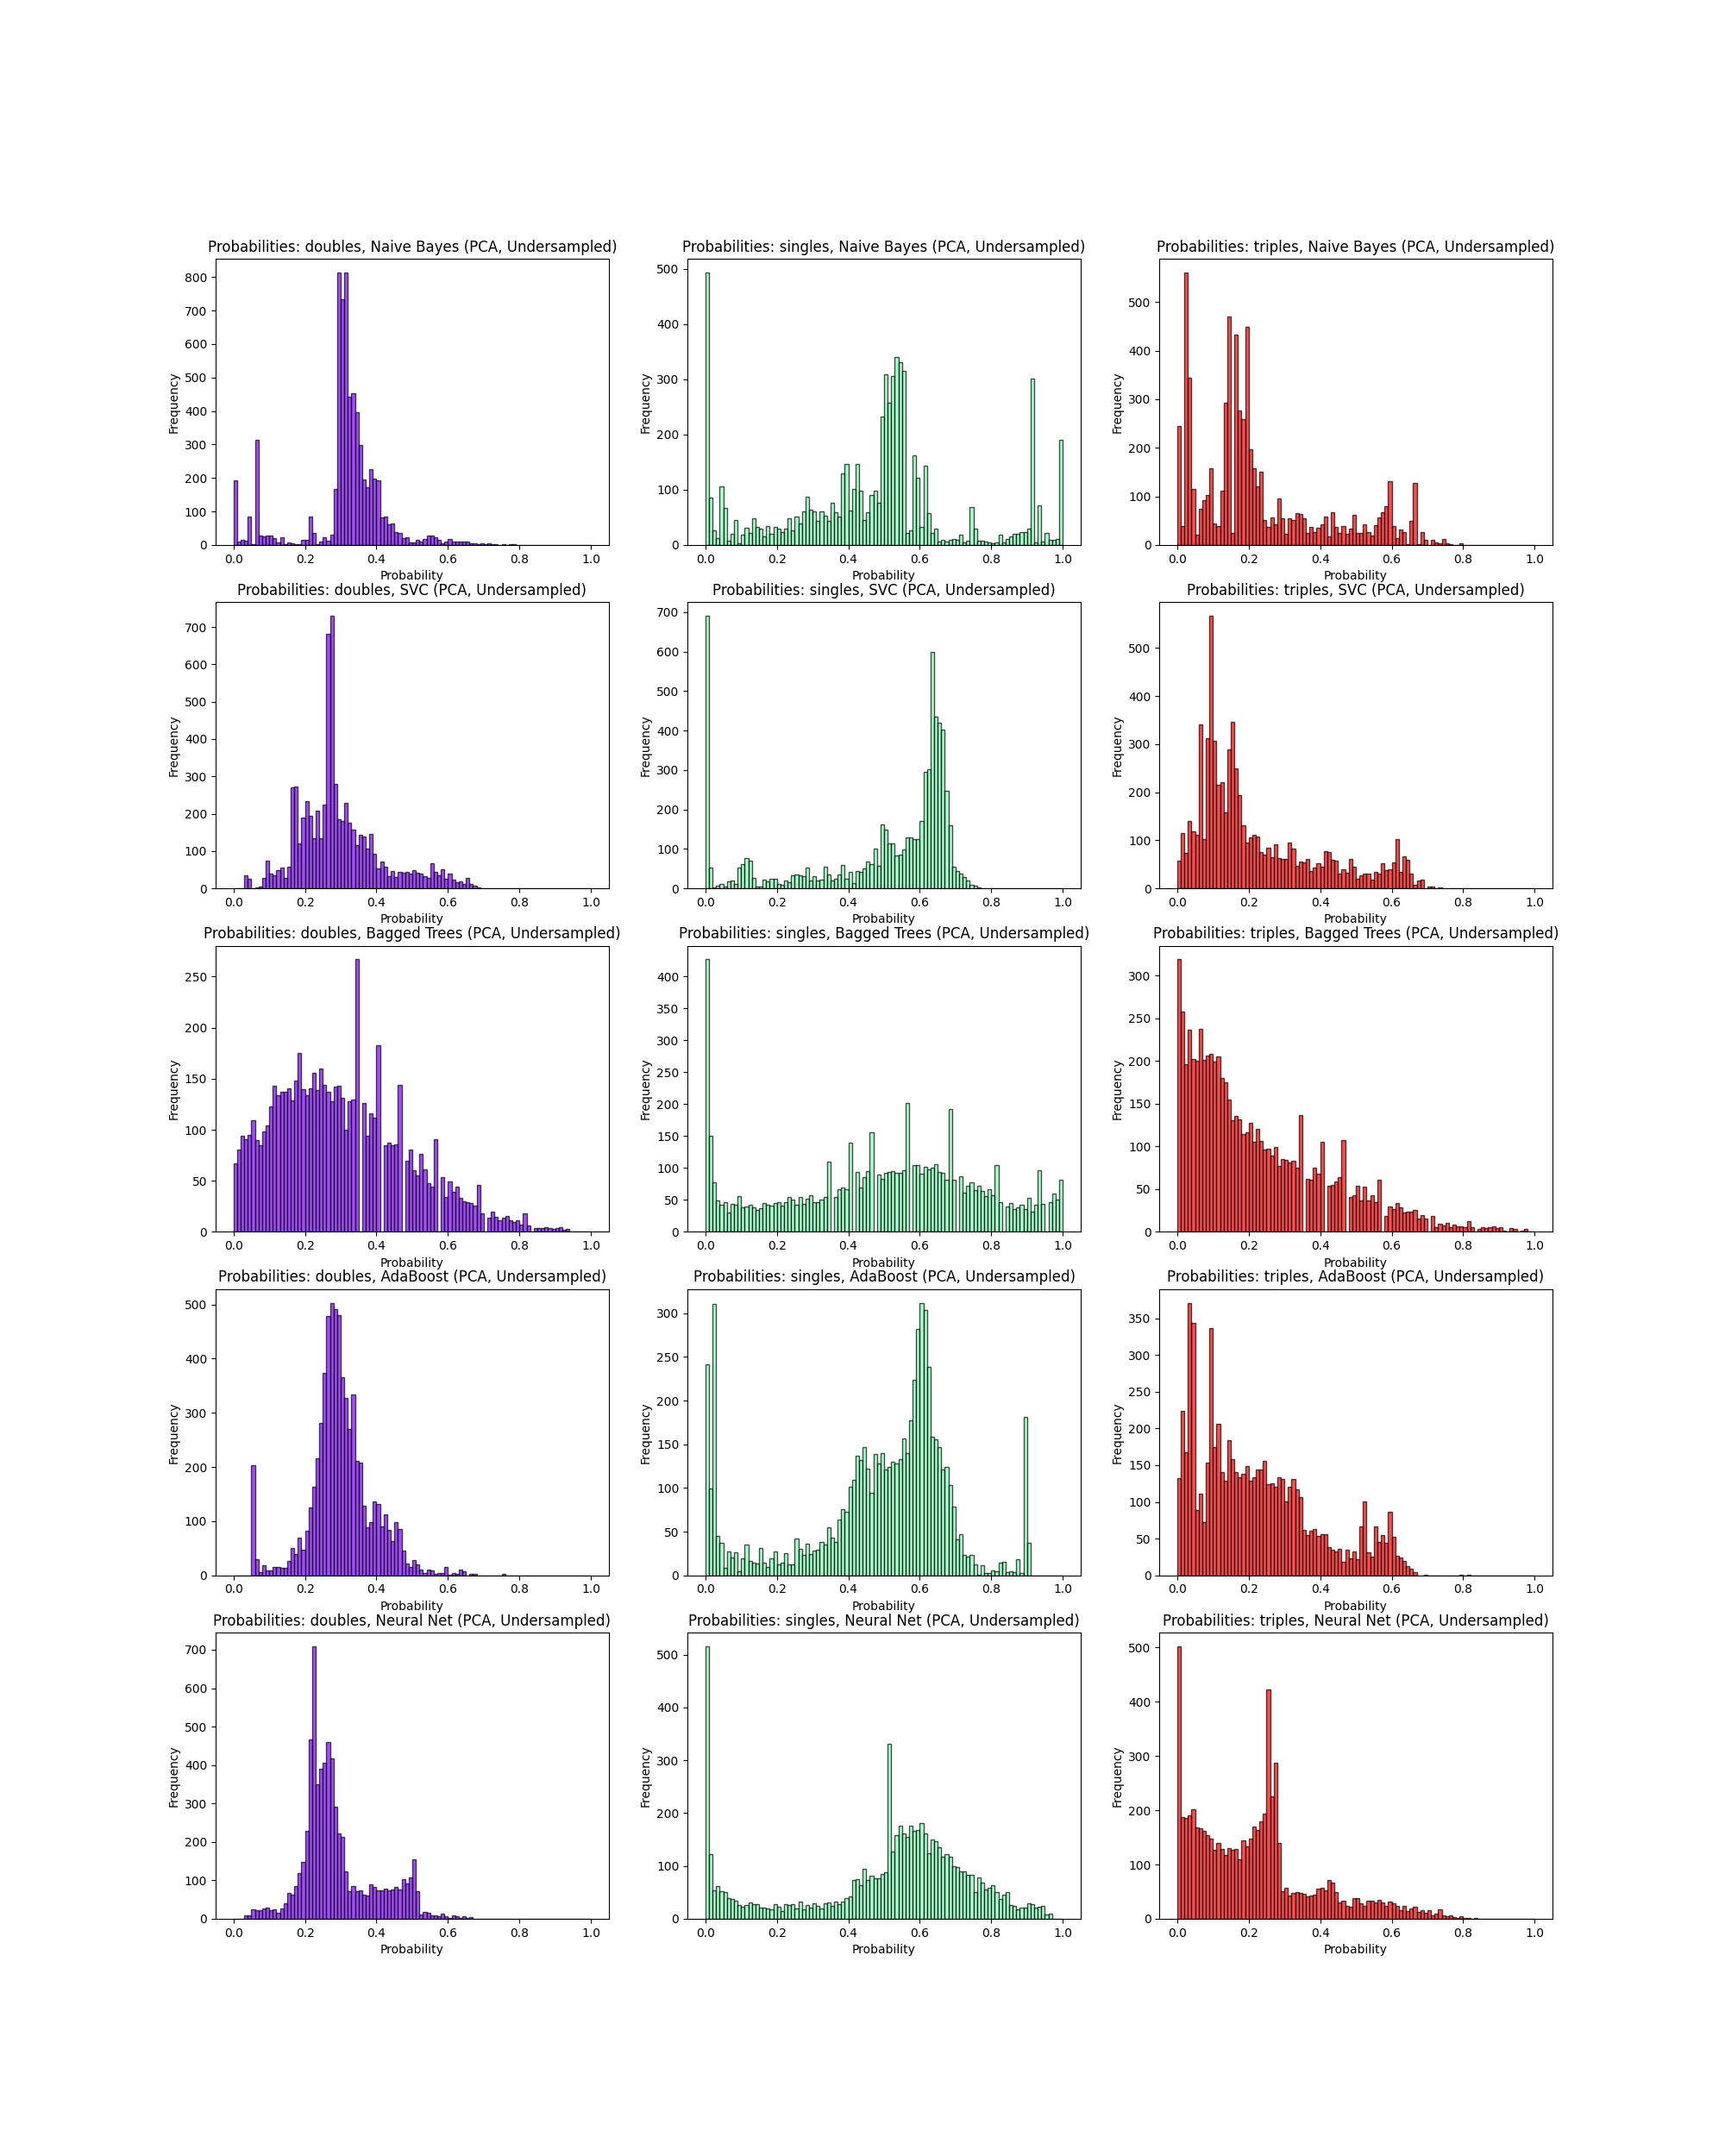

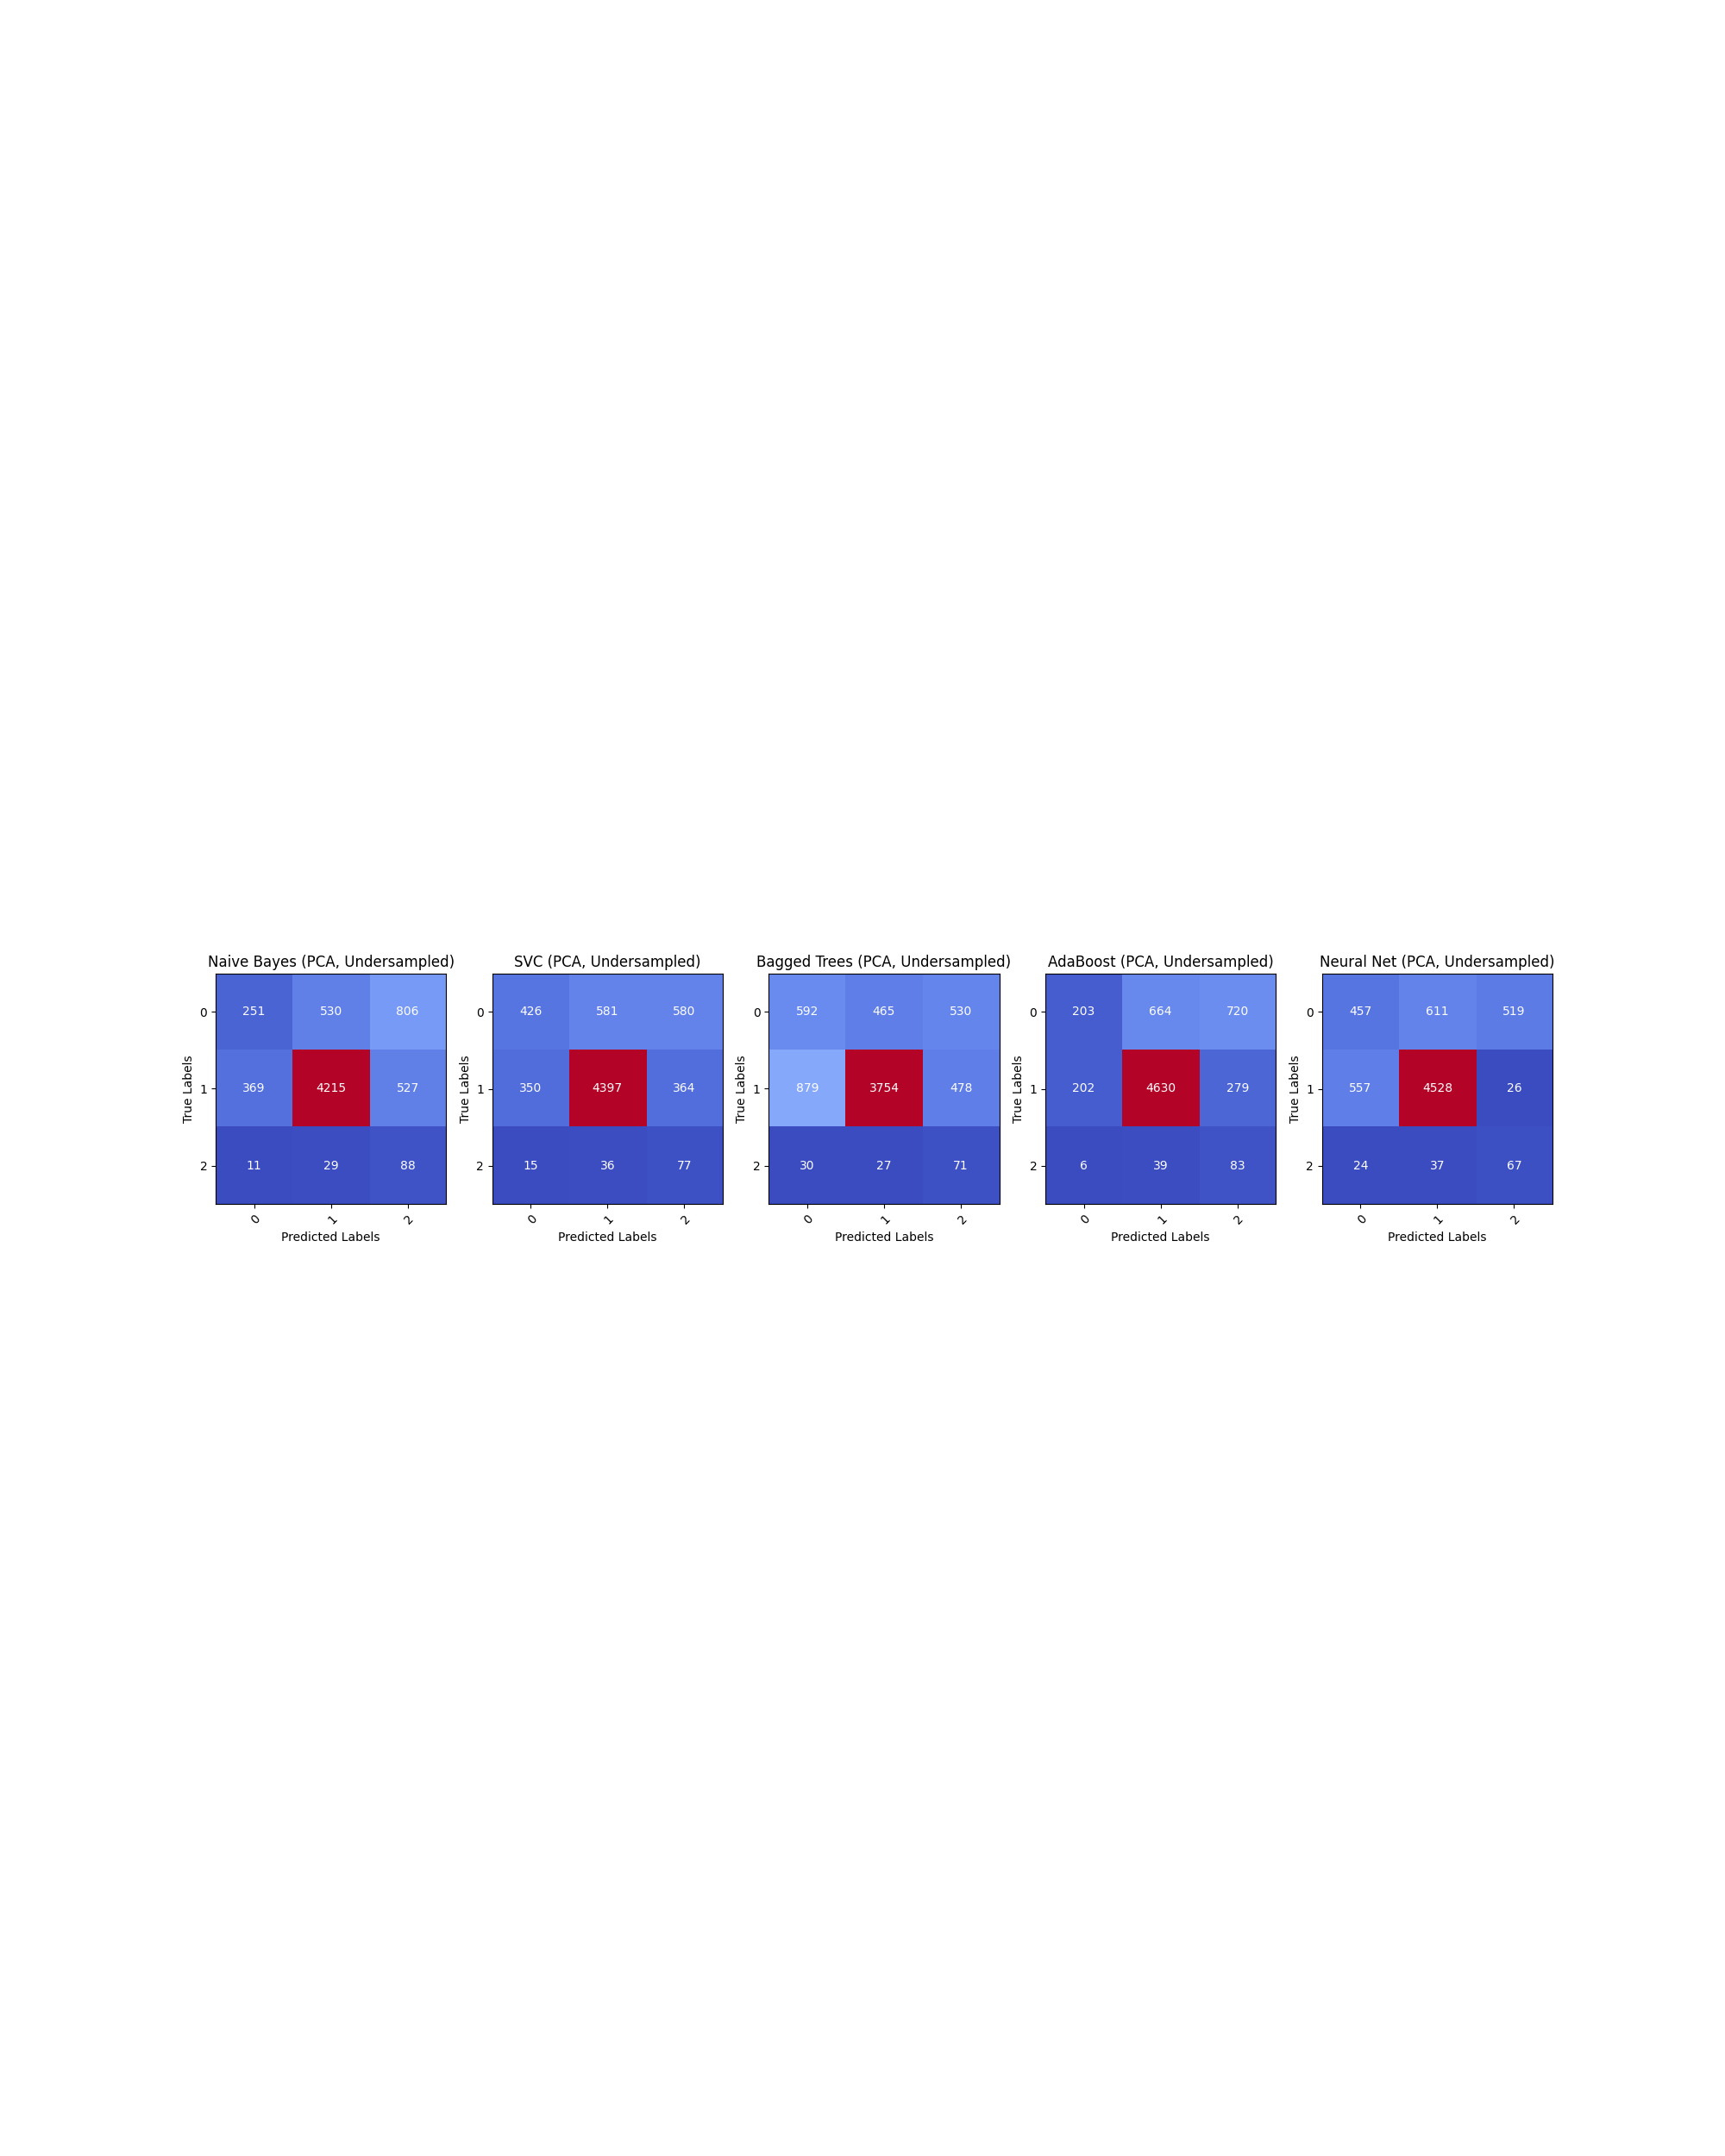

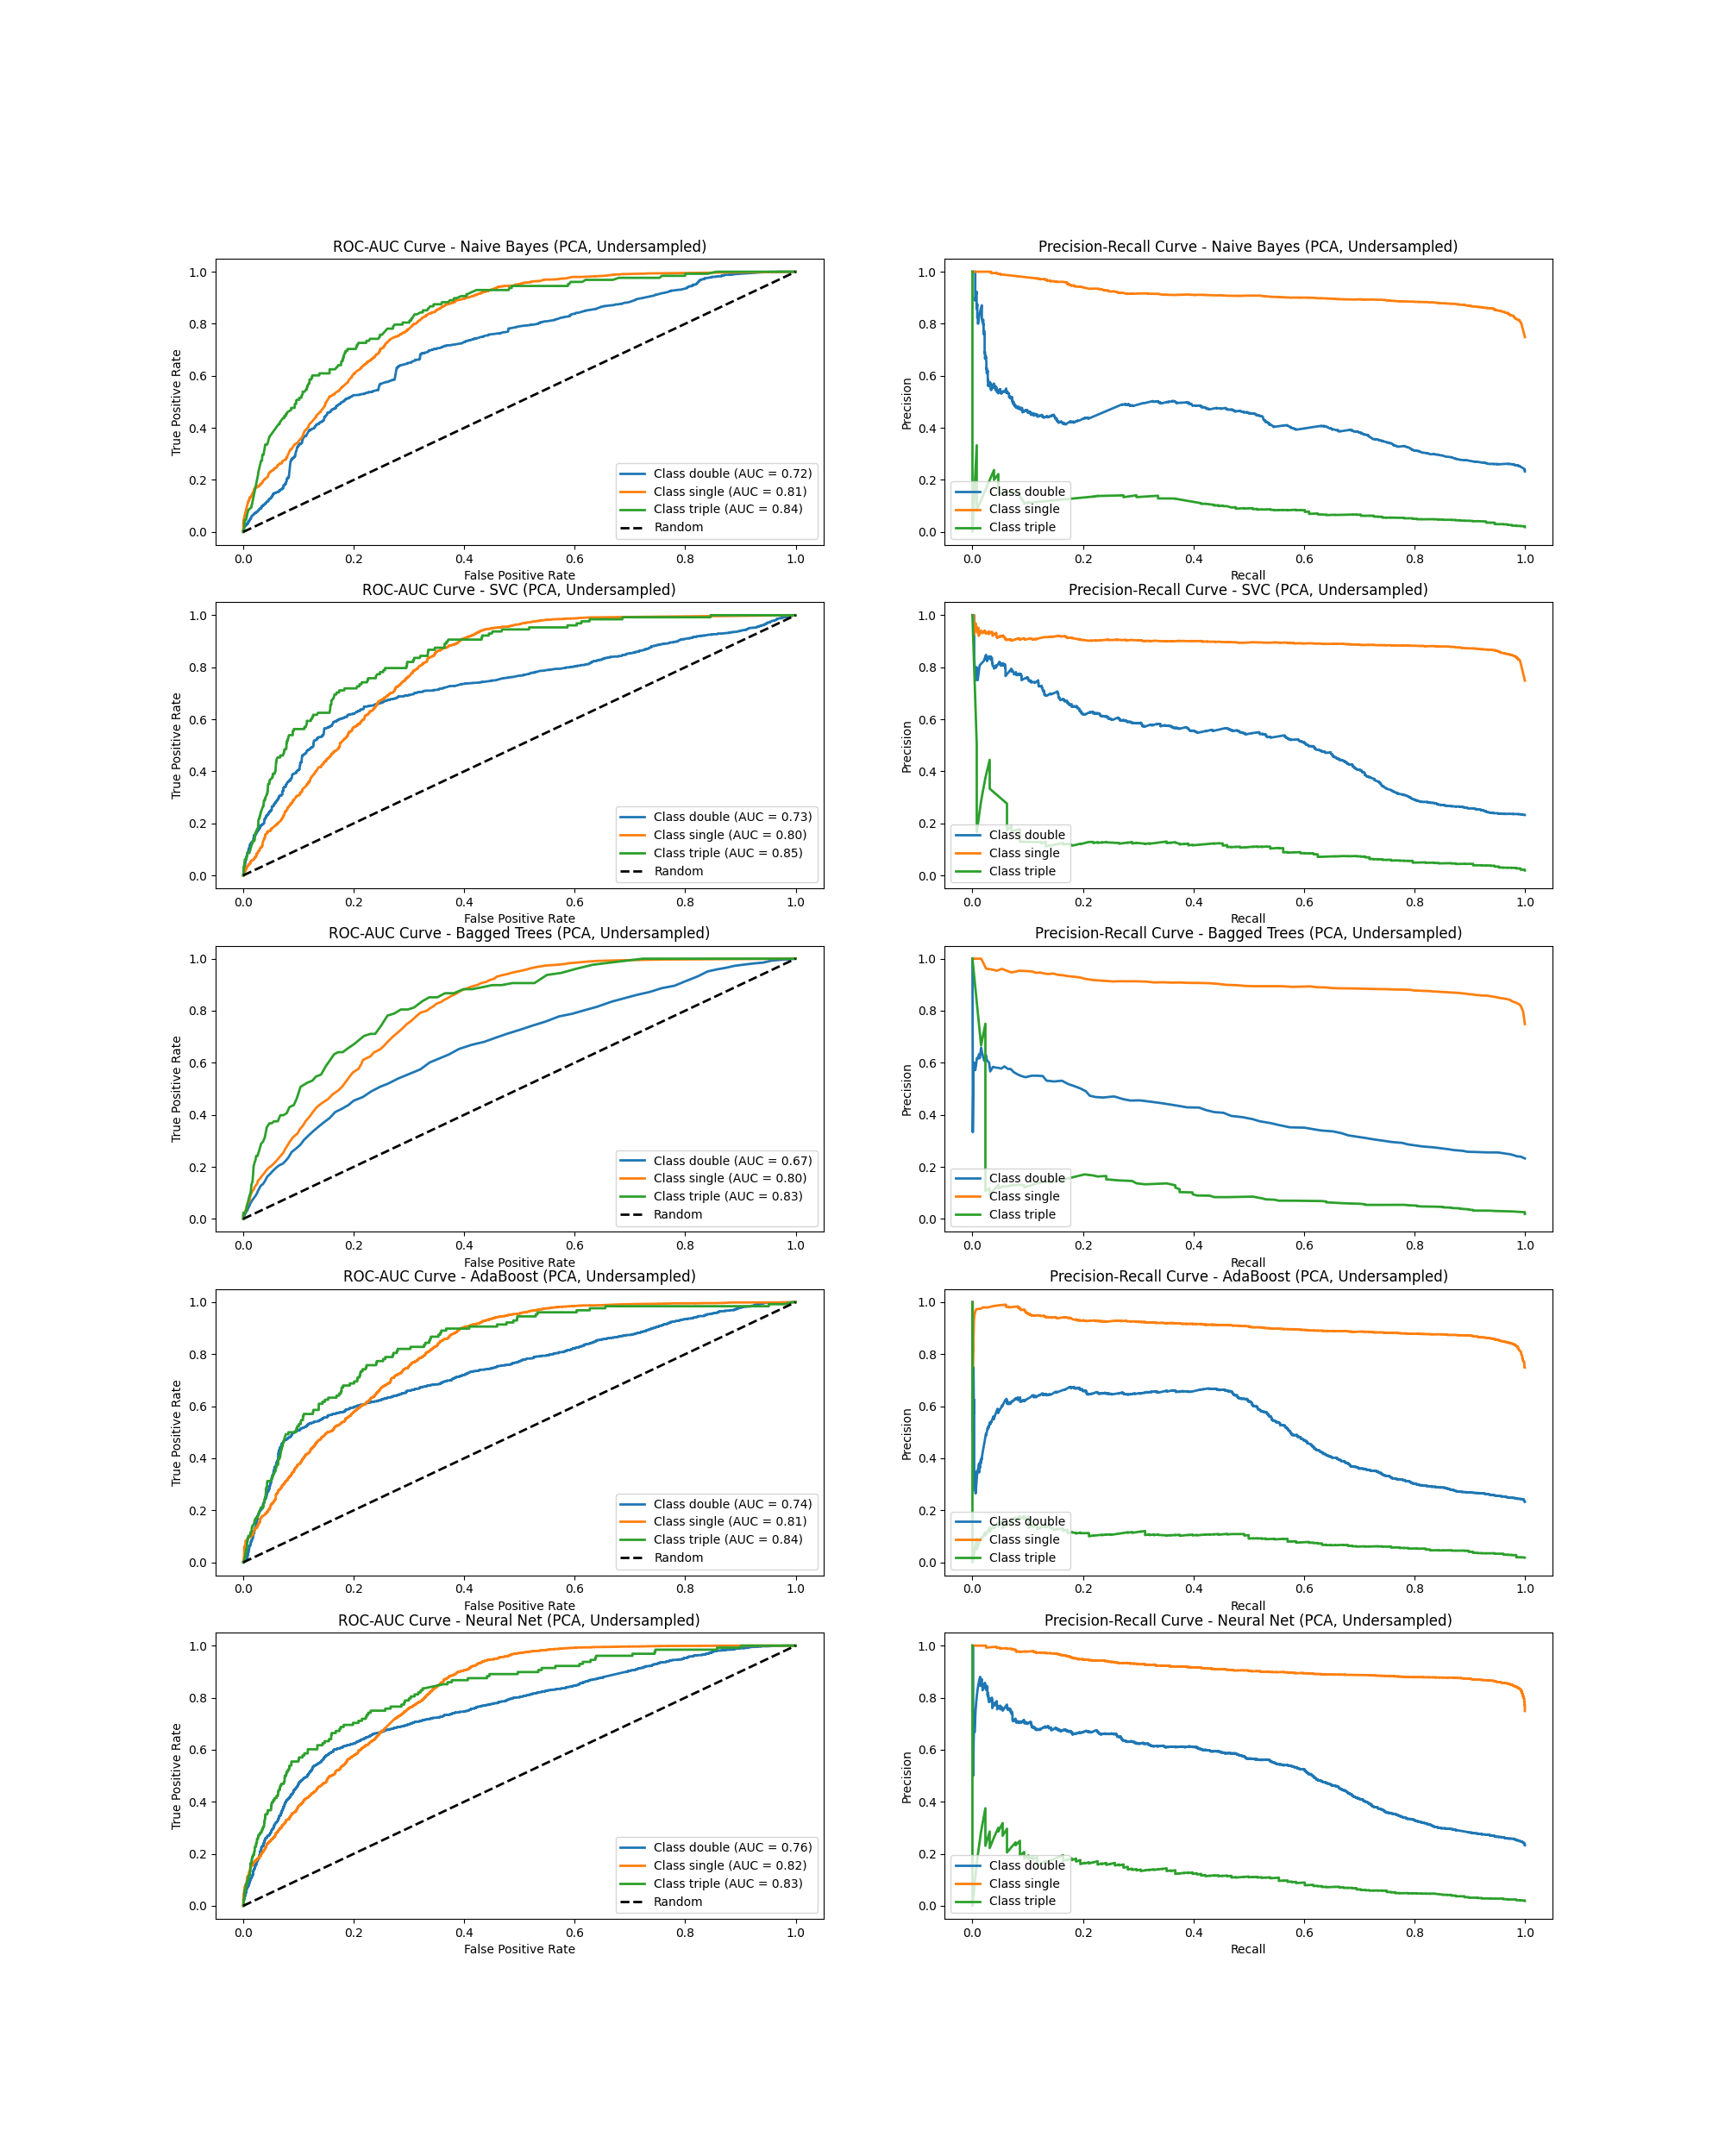

In [27]:
# Create an empty DataFrame to store the metrics
results_df = pd.DataFrame(columns=list(metrics.keys()))

classes = np.unique(y_train)
num_classifiers = len(classifiers)

# Create a figure to hold the confusion matrices and ROC-AUC, Precision-Recall Curves
fig, axes = plt.subplots(nrows= num_classifiers, ncols=3, figsize=(20, 5 * num_classifiers))
fig2, axes2 = plt.subplots(nrows=1, ncols=len(classifiers), figsize=(20, 5 * num_classifiers))
fig3, axes3 = plt.subplots(nrows= num_classifiers, ncols=2, figsize=(20, 5 * num_classifiers))


# Iterate over classifiers
for z, (name, classifier) in enumerate(classifiers):
    print('Evaluating...', name)

    # Undersample Doubles and Triples in Data
    rus = RandomUnderSampler(random_state=69)

    if name == "Neural Net (PCA, Undersampled)":
      # Fit PCA
      pca = PCA(n_components=3, random_state = 69)

      X_train_transformed = preprocessor.fit_transform(X_train)
      X_test_transformed = preprocessor.transform(X_test)

      X_train_pca = pca.fit_transform(X_train_transformed)
      X_test_pca = pca.transform(X_test_transformed)

      X_train_resample, y_train_resample = rus.fit_resample(X_train_pca, y_train)
      print('Count of Classes (Training Data): 2B, 1B, 3B', np.unique(y_train_resample, return_counts = True))


      # Convert test data to the appropriate data type
      X_test_pca = X_test_pca.astype(np.float32)

      model = tf.keras.models.Sequential([tf.keras.layers.Dense(3, activation='relu',input_shape=(X_train_resample.shape[1],)),
                                          tf.keras.layers.Dense(32, activation='relu'),
                                          tf.keras.layers.Dense(3, activation='softmax')])

      # Compile the model
      model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
      model.fit(X_train_resample, y_train_resample, epochs=100, batch_size=32, verbose=0)

      # Predict probability distributions for the test set
      y_pred_proba = model.predict(X_test_pca)

      # Convert predicted probabilities to class labels
      y_pred = tf.argmax(y_pred_proba, axis=1)

    else:
      # Fit PCA
      pca = PCA(n_components=3, random_state = 69)

      # Create the pipeline
      pipeline = make_pipeline(
          preprocessor,
          pca,
          rus,
          classifier
      )

      # Train the pipeline
      pipeline.fit(X_train, y_train)


      X_test_transformed = pipeline[0].transform(X_test)
      X_test_pca = pipeline[1].transform(X_test_transformed)


      # Make predictions on the test set
      y_pred = pipeline[3].predict(X_test_pca)
      y_pred_proba = pipeline[3].predict_proba(X_test_pca)


    # Plot Probability Distribution For Each Class For Each Classifier
    ax_prob = axes
    plot_probability_histograms(name, y_pred_proba, ax_prob, z, label_encoder)


    # Calculate and store the metrics for the classifier
    results = {key: None for key in metrics.keys()}

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)


    # Iterate over the list and find the index of the tuple containing the model name
    ax_index = None
    for i, item in enumerate(classifiers):
        if name in item:
            ax_index = i
            break

    # Plot confusion matrix
    ax_cm = axes2[ax_index]
    plot_confusion_matrix(cm, ax_cm, name, classes)


    # Define each row of matplotlib figure, plot ROC-AUC and Precision-Recall
    ax_rocauc = axes3[z, 0]
    ax_pr = axes3[z, 1]

    plot_rocauc_pr_rec(name, ax_rocauc, ax_pr, y_test, y_pred_proba, classes, label_encoder)

    # Add all metrics to dictionary, add to DataFrame
    for metric_name, metric_func in metrics.items():
        if metric_name in ['Precision', 'Recall', 'F1-Score']:
            metric_value = metric_func(y_test, y_pred, average='weighted')
        elif metric_name == 'ROC-AUC':
          metric_value = metric_func(y_test, y_pred_proba, average = 'weighted', multi_class = 'ovr')
        elif metric_name == "Cohen's Kappa":
          metric_value = metric_func(y_test, y_pred)

        results[metric_name] = metric_value

    # Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract precision values from the report
    class_names = list(report.keys())
    class_names.remove('accuracy') # Remove 'accuracy' from class names
    class_names.remove('macro avg') # Remove 'macro avg' from class names
    class_names.remove('weighted avg') # Remove 'weighted avg' from class names

    for class_name in class_names:
      results[f'Recall, {label_encoder.inverse_transform([int(class_name)])[0]}'] = report[class_name]['recall']

    #print(results)

    # Add the results to the DataFrame
    results_df.loc[name] = pd.Series(results)

In [19]:
# Print the results
results_df

,Precision,Recall,F1-Score,ROC-AUC,Cohen's Kappa,"Recall, double","Recall, single","Recall, triple"
"Naive Bayes (PCA, Undersampled)",0.760854,0.665837,0.692525,0.795128,0.263678,0.149338,0.824887,0.718750
"SVC (PCA, Undersampled)",0.780377,0.711105,0.731124,0.789677,0.319887,0.257089,0.854627,0.609375
"Bagged Decision Trees (PCA, Undersampled)",0.741279,0.619689,0.669531,0.763324,0.229555,0.352237,0.704363,0.554688
"AdaBoost Classifier (PCA, Undersampled)",0.771301,0.728831,0.715235,0.795837,0.304113,0.112791,0.922129,0.648438
"Probabilistic Neural Net (PCA, Undersampled)",0.773992,0.712423,0.732531,0.799978,0.324101,0.278513,0.849540,0.617188
